In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch

import sys 
import numpy as np 
import matplotlib.pyplot as plt

from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable
from six import add_metaclass
from contextlib import contextmanager
import random
import pickle
import os
import time

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

Python: 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]
Pytorch: 1.3.1


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


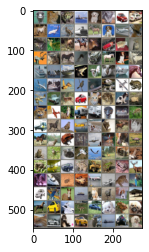

In [2]:
batch_size = 128
# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define series of transforms to pre process images 
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),

    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10('/home/fmejia/fmejia/Cypercat/cyphercat/datasets//', train=True, transform=transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10('/home/fmejia/fmejia/Cypercat/cyphercat/datasets//', train=False, transform=transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=batch_size, shuffle=True, num_workers=2)

testset_list = []
test_batch_size = 128
for i in range(int(5 * test_batch_size / batch_size)):
    testset_list.append(cifar10_testset)

cifar10_testset5 = torch.utils.data.ConcatDataset(testset_list)
cifar10_testloader5 = torch.utils.data.DataLoader(cifar10_testset5, batch_size=test_batch_size, shuffle=True, num_workers=2)


# helper function to unnormalize and plot image 
def imshow(img, filename = None):
    mean = torch.tensor((0.4914, 0.4822, 0.4465)).to(device)
    mean = mean.view(-1,1,1).cpu().detach().numpy()
    var = torch.tensor((0.2023, 0.1994, 0.2010)).to(device)
    var = var.view(-1,1,1).cpu().detach().numpy()
    
    img = np.array(img)
    img = (img*var) + mean
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    try:
        plt.savefig(filename)
        plt.show()
    except:
        plt.show()
    
    
# display sample from dataset 
imgs,labels = iter(cifar10_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

In [3]:
##############################################################################
# ReparamModule
##############################################################################


class PatchModules(type):
    def __call__(cls, *args, **kwargs):
        r"""Called when you call ReparamModule(...) """
        net = type.__call__(cls, *args, **kwargs)

        # collect weight (module, name) pairs
        # flatten weights
        w_modules_names = []

        for m in net.modules():
            for n, p in m.named_parameters(recurse=False):
                if p is not None:
                    w_modules_names.append((m, n))
            for n, b in m.named_buffers(recurse=False):
                if b is not None:
                    print((
                        '{} contains buffer {}. The buffer will be treated as '
                        'a constant and assumed not to change during gradient '
                        'steps. If this assumption is violated (e.g., '
                        'BatchNorm*d\'s running_mean/var), the computation will '
                        'be incorrect.').format(m.__class__.__name__, n))

        net._weights_module_names = tuple(w_modules_names)

        # Put to correct device before we do stuff on parameters
        net = net.to(device)

        ws = tuple(m._parameters[n].detach() for m, n in w_modules_names)

        assert len(set(w.dtype for w in ws)) == 1

        # reparam to a single flat parameter
        net._weights_numels = tuple(w.numel() for w in ws)
        net._weights_shapes = tuple(w.shape for w in ws)
        with torch.no_grad():
            flat_w = torch.cat([w.reshape(-1) for w in ws], 0)

        # remove old parameters, assign the names as buffers
        for m, n in net._weights_module_names:
            delattr(m, n)
            m.register_buffer(n, None)

        # register the flat one
        net.register_parameter('flat_w', nn.Parameter(flat_w, requires_grad=True))

        return net


@add_metaclass(PatchModules)
class ReparamModule(nn.Module):
    def _apply(self, *args, **kwargs):
        rv = super(ReparamModule, self)._apply(*args, **kwargs)
        return rv

    def get_param(self, clone=False):
        if clone:
            return self.flat_w.detach().clone().requires_grad_(self.flat_w.requires_grad)
        return self.flat_w
    
    @contextmanager
    def unflatten_weight(self, flat_w):
        ws = (t.view(s) for (t, s) in zip(flat_w.split(self._weights_numels), self._weights_shapes))
        for (m, n), w in zip(self._weights_module_names, ws):
            setattr(m, n, w)
        yield
        for m, n in self._weights_module_names:
            setattr(m, n, None)            

    def forward_with_param(self, inp, new_w):
        with self.unflatten_weight(new_w):
            return nn.Module.__call__(self, inp)

    def __call__(self, inp):
        return self.forward_with_param(inp, self.flat_w)

    # make load_state_dict work on both
    # singleton dicts containing a flattened weight tensor and
    # full dicts containing unflattened weight tensors...
    def load_state_dict(self, state_dict, *args, **kwargs):
        if len(state_dict) == 1 and 'flat_w' in state_dict:
            return super(ReparamModule, self).load_state_dict(state_dict, *args, **kwargs)
        with self.unflatten_weight(self.flat_w):
            flat_w = self.flat_w
            del self.flat_w
            super(ReparamModule, self).load_state_dict(state_dict, *args, **kwargs)
        self.register_parameter('flat_w', flat_w)

    def reset(self, inplace=True):
        if inplace:
            flat_w = self.flat_w
        else:
            flat_w = torch.empty_like(self.flat_w).requires_grad_()
        with torch.no_grad():
            with self.unflatten_weight(flat_w):
                weights_init(self)
        return flat_w

In [4]:
class VGG(ReparamModule):

    def __init__(self, num_classes = 10):
        super(VGG, self).__init__()
        
        cfg =  [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
#                 layers += [nn.Conv2d(in_channels, in_channels, kernel_size = 2, stride = 2, padding = 0)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)                
                layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        self.features = nn.Sequential(*layers)
#         self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(    
            nn.Linear(512, 64),
            nn.ReLU(True),
#             nn.Dropout(),
            nn.Linear(64, 64),
            nn.ReLU(True),
#             nn.Dropout(),
            nn.Linear(64, num_classes),
        )

    
    def forward(self, x):
        x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

net = VGG()


In [5]:
def weights_init(m):
    def init_func(m):
        classname = m.__class__.__name__
        if classname.startswith('Conv') or classname == 'Linear':
            if getattr(m, 'bias', None) is not None:
                nn.init.constant_(m.bias, 0.0)
            if getattr(m, 'weight', None) is not None:
                if classname == 'Linear':           
                    nn.init.xavier_normal_(m.weight)
                if classname.startswith('Conv'):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

        elif 'Norm' in classname:
            if getattr(m, 'weight', None) is not None:
                m.weight.data.fill_(1)
            if getattr(m, 'bias', None) is not None:
                m.bias.data.zero_()
    m.apply(init_func)
    return(m)

# net.apply(weights_init)
net.reset()


Parameter containing:
tensor([-0.1481,  0.0267,  0.0350,  ...,  0.0000,  0.0000,  0.0000],
       device='cuda:0', requires_grad=True)

In [6]:
def train(net, data_loader, test_loader, optimizer, criterion, n_epochs, classes=None, verbose=False):
#     losses = []
    train_accuracy = []
    test_accuracy = []
    
    for epoch in range(n_epochs):
        net.train()
        total = 0
        correct = 0
        for i, batch in enumerate(data_loader):

            imgs, labels, index = batch
            imgs, labels = imgs.to(device), labels.to(device)
            if i == 0:
                imshow(imgs[0,:,:,:].squeeze().cpu().detach().numpy()) 
            optimizer.zero_grad()

            outputs = net(imgs)
            
            ## accuracy calc
            predicted = outputs.argmax(dim=1)
            total += imgs.size(0)
            correct += predicted.eq(labels).sum().item()
            ##

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def eval_target_net(net, testloader, classes=None):

    if classes is not None:
        class_correct = np.zeros(10)
        class_total = np.zeros(10)
    total = 0
    correct = 0
    with torch.no_grad():
        net.eval()
        for i, (imgs, lbls) in enumerate(testloader):

            imgs, lbls = imgs.to(device), lbls.to(device)

            output = net(imgs)

            predicted = output.argmax(dim=1)

            total += imgs.size(0)
            correct += predicted.eq(lbls).sum().item()

            if classes is not None:
                for prediction, lbl in zip(predicted, lbls):

                    class_correct[lbl] += prediction == lbl
                    class_total[lbl] += 1
             
    if classes is not None:
        for i in range(len(classes)):
            print('Accuracy of %s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    print("\nTotal accuracy = %.2f %%\n\n" % (100*(correct/total)) )
    
    return((100*(correct/total)))

In [7]:
criterion = nn.CrossEntropyLoss()
net.to(device)
optimizer_model = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)

In [8]:
net.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): R

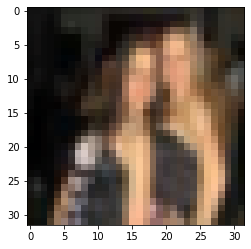

In [9]:
imgs, lbls = cifar10_trainset.__getitem__(18310)
imshow(imgs.squeeze().cpu().detach().numpy())

## Double backward

In [10]:
class MyDataset():
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __getitem__(self, index):
        data, target = self.dataset[index]        
        return data, target, index

    def __len__(self):
        return len(self.dataset)


In [11]:
net.reset()
# restart split
cifar10_trainset = torchvision.datasets.CIFAR10('/home/fmejia/fmejia/Cypercat/cyphercat/datasets//', train=True, transform=transform, download=True)
trainset = MyDataset(cifar10_trainset)

cifar10_trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


In [12]:
def weighted_cross_entropy(logits, label, weight=None):
    reduction = 'none'
    ignore_index = -100
    l = F.nll_loss(F.log_softmax(logits, 1), label, None, None, ignore_index, None, reduction)
    return (l*weight).sum()/weight.size()[0]
#     if weight.sum() == 0:
#         print('weights are zero')
#         return (l*weight).sum()
#     return (l*weight).sum()/weight.sum()

In [13]:
criterion = nn.CrossEntropyLoss()

lr_synthetic = 1e3
lr = 0.01

data_weights = torch.ones(len(cifar10_trainloader.dataset), requires_grad=True, device = device)


optimizer = optim.Adam([data_weights], lr = lr_synthetic, betas=(0.5, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40,
                                                   gamma=0.5)


In [14]:
# train(net, cifar10_trainloader, cifar10_testloader, optimizer_model, criterion, n_epochs = 10, classes=classes, verbose=False)

In [15]:
cifar10_trainset = torchvision.datasets.CIFAR10('/home/fmejia/fmejia/Cypercat/cyphercat/datasets//', train=True, transform=transform, download=True)
trainset = MyDataset(cifar10_trainset)
cifar10_trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
# cifar10_testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)


Files already downloaded and verified


In [16]:
def seed_everything(seed=1234):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


In [17]:
# losses = []  
# losses_syn = []
# losses_miss = []
# losses_miss2 = []
# accuracy = []
# criterion_miss2 = nn.BCEWithLogitsLoss()
# criterion_miss = nn.L1Loss()
# lr_synthetic = 1e-2

# grad_val = []
# # for i in range(1000):
# n_epoch = 30
# n_restarts = 100
# data_weights = torch.zeros(len(cifar10_trainloader.dataset), requires_grad=True, device = device)
# data_mom = torch.zeros(len(cifar10_trainloader.dataset), requires_grad=True, device = device)

# for ii in range(n_restarts):
#     print('n_restart = ' + str(ii))
#     net = VGG()
#     net.reset() 
#     net.train()            
#     w = torch.tensor(net.get_param().cpu().detach().numpy(), requires_grad = True).to(device)    
    
#     for jj in range(n_epoch):
#         t=time.time()
#         for batch, batch_eval in zip(cifar10_trainloader, cifar10_testloader5):        
#             imgs, labels, ind = batch
#             imgs, labels = imgs.to(device), labels.to(device) 
            
#             imgs_eval, labels_eval = batch_eval
#             imgs_eval, labels_eval = imgs_eval.to(device), labels_eval.to(device) 
            
#             ind = ind.to(device)
#             ww = (torch.tensor(data_weights[ind], requires_grad=True, device = device))

#             ## train with weighted data
#             with torch.enable_grad():
#                 output = net.forward_with_param(imgs, w)
#                 loss = weighted_cross_entropy(output, labels, torch.sigmoid(ww))
#             gw, = torch.autograd.grad(loss, w, grad_outputs = torch.tensor(lr).to(device),create_graph=True) 
            
#             net.zero_grad()                                            
# #             losses.append(loss.item())
#             losses.append(loss.item() * imgs.size(0) / torch.sigmoid(ww).sum())

#             # get eval performance          
#             with torch.enable_grad():
#                 output = net.forward_with_param(imgs_eval, w)
#                 l0 = criterion(output, labels_eval)

#             dw, = torch.autograd.grad(l0, (w,))
#             dgw = dw.neg()

#             hvp_grad = torch.autograd.grad(
#                 outputs=(gw,),
#                 inputs=[ww],
#                 grad_outputs=(dgw,)
#             )

# #             data_weights.data[ind] = data_weights.data[ind] - lr_synthetic * hvp_grad[0]
#             data_mom.data[ind] = 0.9 * data_mom.data[ind] + lr_synthetic * hvp_grad[0]
#             data_weights.data[ind] = data_weights.data[ind] - data_mom.data[ind]
            
#             net.zero_grad()
#             with torch.no_grad():
#                 w = w.sub(gw).requires_grad_()
#         print('epoch ' + str(jj))    
#         print(time.time()-t) 
#         ## normalize per class
#         class_weight = torch.zeros(10)
#         for i, weights in enumerate(data_weights):
#             class_weight[trainset.dataset.targets[i]] += weights
#         class_norm = class_weight/len(trainset)*10.

#         for i in range(len(trainset)):
#             data_weights[i] += -class_norm[trainset.dataset.targets[i]]

# #     output = net.forward_with_param(imgs_eval, w)
# #     loss = criterion(output, labels_eval)
#     loss_sum = 0
#     for batch in cifar10_testloader:        
#         imgs, labels = batch
#         imgs, labels = imgs.to(device), labels.to(device) 
#         output = net.forward_with_param(imgs, w)
#         loss = criterion(output, labels)
#         loss_sum += loss.item()
#     losses_syn.append(loss_sum)

#     print('accuracy plots')
    
#     plt.plot(losses)
#     plt.show() 
#     plt.plot(losses_syn)
#     plt.grid(True)
#     plt.show()        
# #     print((F.sigmoid(data_weights).round().eq(torch.ones(50000).to(device)).sum()).float()/50000)
#     plt.hist(F.sigmoid(data_weights).squeeze().cpu().detach().numpy())
#     plt.show()
#     with open('data_weights_DB_class_norm.pickle', 'wb') as f:
#         pickle.dump(data_weights, f)
# #     plt.hist(F.sigmoid(data_weights[ind00[class_idx]]).squeeze().cpu().detach().numpy())
# #     plt.show()
# #     plt.hist(F.sigmoid(data_weights[ind00]).squeeze().cpu().detach().numpy())
# #     plt.show()



In [18]:
def eval_target_net(net, testloader, w, classes=None):

    if classes is not None:
        class_correct = np.zeros(10)
        class_total = np.zeros(10)
    total = 0
    correct = 0
    with torch.no_grad():
        net.eval()
        for i, (imgs, lbls) in enumerate(testloader):

            imgs, lbls = imgs.to(device), lbls.to(device)

            output = net.forward_with_param(imgs, w)

            predicted = output.argmax(dim=1)

            total += imgs.size(0)
            correct += predicted.eq(lbls).sum().item()

            if classes is not None:
                for prediction, lbl in zip(predicted, lbls):

                    class_correct[lbl] += prediction == lbl
                    class_total[lbl] += 1
             
    if classes is not None:
        for i in range(len(classes)):
            print('Accuracy of %s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    print("\nTotal accuracy = %.2f %%\n\n" % (100*(correct/total)) )
    
    return((100*(correct/total)))

In [19]:
def get_batch(dataloader, ind_list):
    imgs = torch.zeros(len(ind_list), 3, 32,32)
    labels = torch.zeros(len(ind_list))
    for count, i in enumerate(ind_list): 
        imgs[count,:,:,:], labels[count], _ = dataloader.dataset.__getitem__(i)
    return imgs, labels     

n_restart = 0


/home/fmejia/anaconda3/envs/pytorch1.4/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch 0
accuracy plots


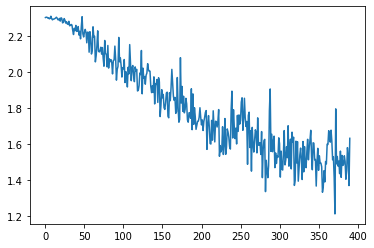


Total accuracy = 46.21 %


epoch 1
accuracy plots


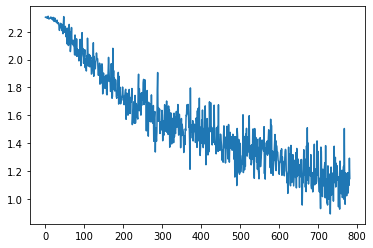


Total accuracy = 58.45 %


epoch 2
accuracy plots


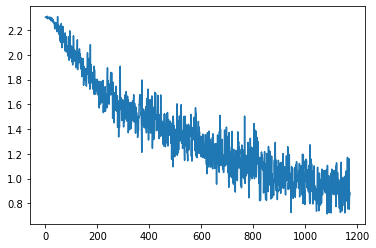


Total accuracy = 66.10 %


epoch 3
accuracy plots


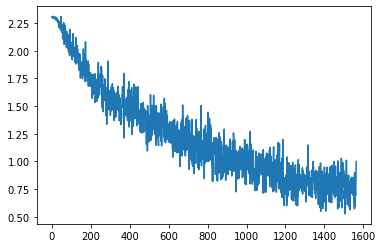


Total accuracy = 73.32 %


epoch 4
accuracy plots


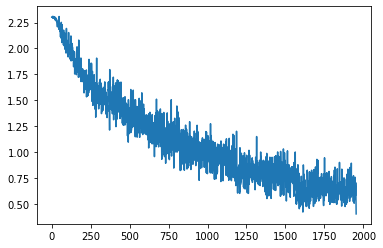


Total accuracy = 74.24 %


1
0.40102726221084595
2
0.532401442527771


/home/fmejia/anaconda3/envs/pytorch1.4/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


3
0.6680557131767273
4
0.7030351161956787
5
0.636425256729126
6
0.5754799246788025
7
0.7542383670806885
8
0.6315541863441467
9
0.7278496623039246
10
0.6366488933563232
11
0.5375251173973083
12
0.6635671257972717
13
0.5228416323661804
14
0.5018748044967651
15
0.5568243861198425
16
0.6953077912330627
17
0.6789817214012146
18
0.7768374681472778
19
0.5331659317016602
20
0.6267452836036682
21
0.7088543772697449
22
0.640742301940918
23
0.5785813331604004
24
0.7716065645217896
25
0.6881296634674072
26
0.7771219611167908
27
0.6458680033683777
28
0.6967241764068604
29
0.7934514284133911
30
0.8130314350128174
31
0.7302267551422119
32
0.8920078277587891
33
1.1108423471450806
34
0.7657047510147095
35
1.023131251335144
36
0.973827064037323
37
1.1997214555740356
38
0.9896072149276733
39
1.205031156539917
40
1.6290397644042969
41
1.411560297012329
42
1.9276158809661865
43
2.291642427444458
44
2.4123878479003906
45
2.0655410289764404
46
2.029080390930176
47
2.163069248199463
48
2.096644401550293
49
2.

In [20]:
losses = []  
losses_syn = []
losses_miss = []
losses_miss2 = []
accuracy = []
criterion_miss2 = nn.BCEWithLogitsLoss()
criterion_miss = nn.L1Loss()
lr_synthetic = 1e-2
lr = 0.01
grad_val = []

n_epoch = 5
n_restarts = 1
data_weights = torch.zeros(len(cifar10_trainloader.dataset), requires_grad=True, device = device)
data_mom = torch.zeros(len(cifar10_trainloader.dataset), requires_grad=True, device = device)
ind_list = []
w0 = torch.tensor(net.get_param().cpu().detach().numpy(), requires_grad = True).to(device) 
for ii in range(n_restarts):
    print('n_restart = ' + str(ii))
    net = VGG()
    net.reset() 
    net.train()            
    w = torch.tensor(net.get_param().cpu().detach().numpy(), requires_grad = True).to(device) 
    w0 = torch.tensor(net.get_param().cpu().detach().numpy(), requires_grad = True).to(device) 
    w_mom = torch.zeros(w.size()).to(device)
    ## Forward through training
    for jj in range(n_epoch):
        for batch in cifar10_trainloader:        
            imgs, labels, im_ind = batch
            imgs, labels = imgs.to(device), labels.to(device) 
            ind_list.append(torch.tensor(im_ind))

            ## train with weighted data
            with torch.enable_grad():
                output = net.forward_with_param(imgs, w)
#                 loss = weighted_cross_entropy(output, labels, torch.sigmoid(ww))
                loss = criterion(output, labels)
            gw, = torch.autograd.grad(loss, w, grad_outputs = torch.tensor(lr).to(device),create_graph=True) 
            with torch.no_grad():
                w_mom = 0.9 * w_mom + gw
                w = w.sub(w_mom).requires_grad_()
            net.zero_grad()                                            

            losses.append(loss.item())

        print('epoch ' + str(jj))    
        print('accuracy plots')
    
        plt.plot(losses)
        plt.show() 
        eval_target_net(net, cifar10_testloader, w, classes=None)
#     # Evaluation loss
#     dw = torch.zeros(w.size()).to(device)
#     for batch in cifar10_testloader:
#         imgs, labels = batch
#         imgs, labels = imgs.to(device), labels.to(device) 
#         outputs = net.forward_with_param(imgs, w)
#         loss_test = criterion(outputs, labels) 
#         dummy, = torch.autograd.grad(loss_test, (w,))
#         dw += dummy.detach()
        
    ## Backward through training
    ind_list.reverse()
    count = 0
    for ind in ind_list:
        imgs, labels = get_batch(cifar10_trainloader, ind)

        imgs, labels = imgs.to(device), labels.long().to(device) 

        ww = (torch.tensor(data_weights[ind], requires_grad=True, device = device))
        with torch.no_grad():
            w = w.add(w_mom).requires_grad_()
        ## train with weighted data
        with torch.enable_grad():
            output = net.forward_with_param(imgs, w)
#             loss = weighted_cross_entropy(output, labels, torch.sigmoid(ww))
            loss = criterion(output, labels)
#                 loss = weighted_cross_entropy(output, labels, torch.ones(ww.size()).to(device))
        gw, = torch.autograd.grad(loss, w, grad_outputs = torch.tensor(lr).to(device),create_graph=True) 
        with torch.no_grad():
            w_mom = (w_mom - gw) / 0.9                
        net.zero_grad()                                            
        losses.append(loss.item())
        count +=1
        print(count)
        print(loss.item())
        if loss.item() > 10:
            break
        if count%391 == 0:
            print('epoch ' + str(count/391))    
            print('accuracy plots')

            plt.plot(losses)
            plt.show() 


In [27]:
imgs, labels = get_batch(cifar10_trainloader, ind_list[0])

imgs, labels = imgs.to(device), labels.long().to(device) 
with torch.enable_grad():
        output = net.forward_with_param(imgs, w)
#             loss = weighted_cross_entropy(output, labels, torch.sigmoid(ww))
        loss = criterion(output, labels)
print(loss)
print(ww)

tensor(47.7621, device='cuda:0', grad_fn=<NllLossBackward>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True)


In [22]:
print(w)
print(w_mom)
print(loss)
print(gw)

tensor([-0.0427,  0.0494, -0.1416,  ..., -0.1551,  0.2076, -0.1718],
       device='cuda:0', requires_grad=True)
tensor([3.3155e-04, 5.0395e-04, 5.7866e-04,  ..., 3.6440e-04, 8.4568e-05,
        7.0363e-05], device='cuda:0')
tensor(0.6402, device='cuda:0', grad_fn=<NllLossBackward>)
tensor([1.5760e-04, 1.0323e-04, 4.8550e-05,  ..., 9.4378e-05, 1.7894e-04,
        1.1579e-04], device='cuda:0', grad_fn=<CatBackward>)


In [23]:
## Backward through training
ind_list.reverse()
ind = ind_list[0]
imgs0, labels0 = get_batch(cifar10_trainloader, ind)

imgs0, labels0 = imgs0.to(device), labels0.long().to(device) 
with torch.no_grad():
    w = w.add(w_mom).requires_grad_()
    
with torch.enable_grad():
    output = net.forward_with_param(imgs0, w)
    loss0 = criterion(output, labels)
print(loss0)
gw0, = torch.autograd.grad(loss0, w, grad_outputs = torch.tensor(lr).to(device),create_graph=True) 
print(gw0)



tensor(0.6402, device='cuda:0', grad_fn=<NllLossBackward>)
tensor([1.5774e-04, 1.0345e-04, 4.8772e-05,  ..., 9.4377e-05, 1.7894e-04,
        1.1579e-04], device='cuda:0', grad_fn=<CatBackward>)
